In [1]:
import warnings
from helper import *
from pprint import pprint

In [2]:
warnings.filterwarnings("ignore")

In [3]:
file_dict, file_dir, master_dir = get_data_files()

In [4]:
master_df = pd.DataFrame()

In [5]:
# get the file indexes
available_file_indexes = [{a: [c.split("_")[0][2:] for c in sorted(b)]} for a, b in file_dict.items()]
available_file_indexes = {k: v for d in available_file_indexes for k, v in d.items()}

In [6]:
# sort the file_dict by the file name number
for year, files in file_dict.items():
    file_dict[year] = sorted(files, key=lambda x: int(x.split("_")[0][2:]))

In [7]:
# find top 20 pipes for every file
for year, files in file_dict.items():
    access_index = 0
    for index in available_file_indexes[year]:
        master_df = find_common_pipes(file_index=access_index, file_year=year, top_level_df=master_df,
                                      file_dict=file_dict, master_dir=master_dir, threshold=20)
        access_index += 1

In [8]:
# transpose the dataframe
master_df_T = master_df.copy().T
master_df_T.columns, master_df_T.loc["X", :] = master_df_T.loc[["X"], :].values[0], master_df_T.columns

In [9]:
# create multilevel columns
exp_df = pd.DataFrame(columns=pd.MultiIndex.from_product([master_df_T.columns, ["Pipe TTNr", "Total"]]).unique())

In [10]:
# add the data to the multilevel columns
for i in range(len(master_df_T)):
    exp_df.loc[i, :] = master_df_T.iloc[i, :].values

In [11]:
# drop the unnecessary index
exp_df = exp_df.copy().drop(index=0, inplace=False)

In [12]:
exp_df

KW16_2021           KW17_2021           KW18_2021           KW19_2021  \
     Pipe TTNr   Total   Pipe TTNr   Total   Pipe TTNr   Total   Pipe TTNr   
1   8718649158  2415.0  8718658795  3022.0  8718649167  4831.0  8719905826   
2   8718649167  2415.0  8718649167  2768.0  8718649158  4831.0  8718640762   
3   8718649588  2055.0  8718649158  2768.0  8718649588  4655.0  8718643730   
4   8718649589  1863.0  8718649588  2768.0  8718649589  3197.0  8718649158   
5   8719905826  1845.0  8718686797  2715.0  8718658795  2552.0  8718649588   
6   8718640762  1807.0  8718690584  2715.0  8719905826  2443.0  8718649167   
7   8718690584  1762.0  8716106426  2715.0  8716106426  2280.0  8716010808   
8   8718690267  1762.0  8718690267  2715.0  8716106427  2280.0  8718640787   
9   8718686797  1762.0  8718649589  2588.0  8718690584  2280.0  8718640763   
10  8716106426  1762.0  8718640762  2154.0  8718690267  2280.0  8716010805   
11  8718690149  1705.0  8716106427  1897.0  8718690149  2280.0  8718644049   
12  8716106427  1705.0  8718690149  1897.0  8718686797  2280.0  8718644023   
13  8718658795  1260.0  8718640763  1858.0  8718647378  2157.0  8718656952   
14  8718640787  1204.0  8718640787  1858.0  8718645319  2157.0  8718655925   
15  8718640763  1204.0  8716013640  1668.0  8718654166  2157.0  8718640750   
16  8718643730  1200.0  8719905826  1581.0  8718654057  1931.0  8716010798   
17  8718644049  1176.0  8718654166  1516.0  8718652592  1931.0  8716010802   
18  8718644023  1176.0  8718647378  1516.0  8718640762  1772.0  8716011002   
19  8716010808  1165.0  8718645319  1516.0  8718640763  1748.0  8716010807   
20  8716010798  1145.0  8718658405  1511.0  8718640787  1748.0  8716010804   

             KW20_2021          ...   KW05_2023           KW06_2023          \
     Total   Pipe TTNr   Total  ...   Pipe TTNr   Total   Pipe TTNr   Total   
1   1131.0  8718649158  3593.0  ...  8718696337  3894.0  8718649167  3590.0   
2    882.0  8718649167  3593.0  ...  8750306523  3894.0  8718649158  3590.0   
3    753.0  8718649588  3593.0  ...  8705902546  3894.0  8718649588  3590.0   
4    620.0  8718640787  3009.0  ...  8718651804  3894.0  8718653366  2463.0   
5    620.0  8718640763  3009.0  ...  8718653366  3894.0  8718698387  2463.0   
6    620.0  8718640750  2420.0  ...  8716113919  3894.0  8718699250  2463.0   
7    606.0  8718640754  2356.0  ...  8718696020  3894.0  8716113919  2463.0   
8    604.0  8718699250  2072.0  ...  8718699250  3894.0  8718696337  2463.0   
9    604.0  8718698387  2072.0  ...  8718698387  3894.0  8718651804  2463.0   
10   590.0  8705902546  2072.0  ...  8718649588  2992.0  8718696020  2463.0   
11   436.0  8718696337  2072.0  ...  8718649167  2992.0  8750306523  2463.0   
12   436.0  8718696020  2072.0  ...  8718649158  2992.0  8705902546  2463.0   
13   405.0  8750306523  2072.0  ...  8718640762  2403.0  8718647378  2436.0   
14   405.0  8718653366  2072.0  ...  8718649589  2082.0  8718654166  2436.0   
15   390.0  8716113919  2072.0  ...  8718640763  2065.0  8718645319  2424.0   
16   378.0  8718651804  2072.0  ...  8718640787  2065.0  8718640762  2377.0   
17   378.0  8719905826  1988.0  ...  8718654166  1960.0  8718659493  1979.0   
18   378.0  8718649589  1973.0  ...  8718647378  1960.0  8705902894  1979.0   
19   378.0  8718640752  1972.0  ...  8718645319  1960.0  8705902772  1979.0   
20   378.0  8718640762  1957.0  ...  8718640760  1032.0  8705902494  1979.0   

     KW07_2023           KW08_2023           KW09_2023          
     Pipe TTNr   Total   Pipe TTNr   Total   Pipe TTNr   Total  
1   8719905826  2368.0  8718647378  3196.0  8718653366  2724.0  
2   8718643730  2352.0  8718654166  3196.0  8718698387  2724.0  
3   8718651804  2339.0  8718645319  3136.0  8705902546  2724.0  
4   8718696020  2339.0  8718649167  2805.0  8750306523  2724.0  
5   8718696337  2339.0  8718649158  2805.0  8718651804  2724.0  
6   8716113919  2339.0  8718649588  2805.0  8716113919  2724.0  
7   8718698387  2339.0  87186

In [13]:
# create two sheets in the Excel file
with pd.ExcelWriter(file_dir, engine="openpyxl", mode="w") as writer:
    exp_df.to_excel(writer, sheet_name='General')
    exp_df.T.to_excel(writer, sheet_name='Experimental')

In [14]:
# create multi-level index
three_level_columns = create_three_level_index(df=exp_df)

# # set the multi-level index
exp_df_th = exp_df.copy()
exp_df_th.columns = pd.MultiIndex.from_tuples(three_level_columns)

In [15]:
# format the Excel files
format_general_sheet(file_dir=file_dir)
format_experimental_sheet(file_dir=file_dir)

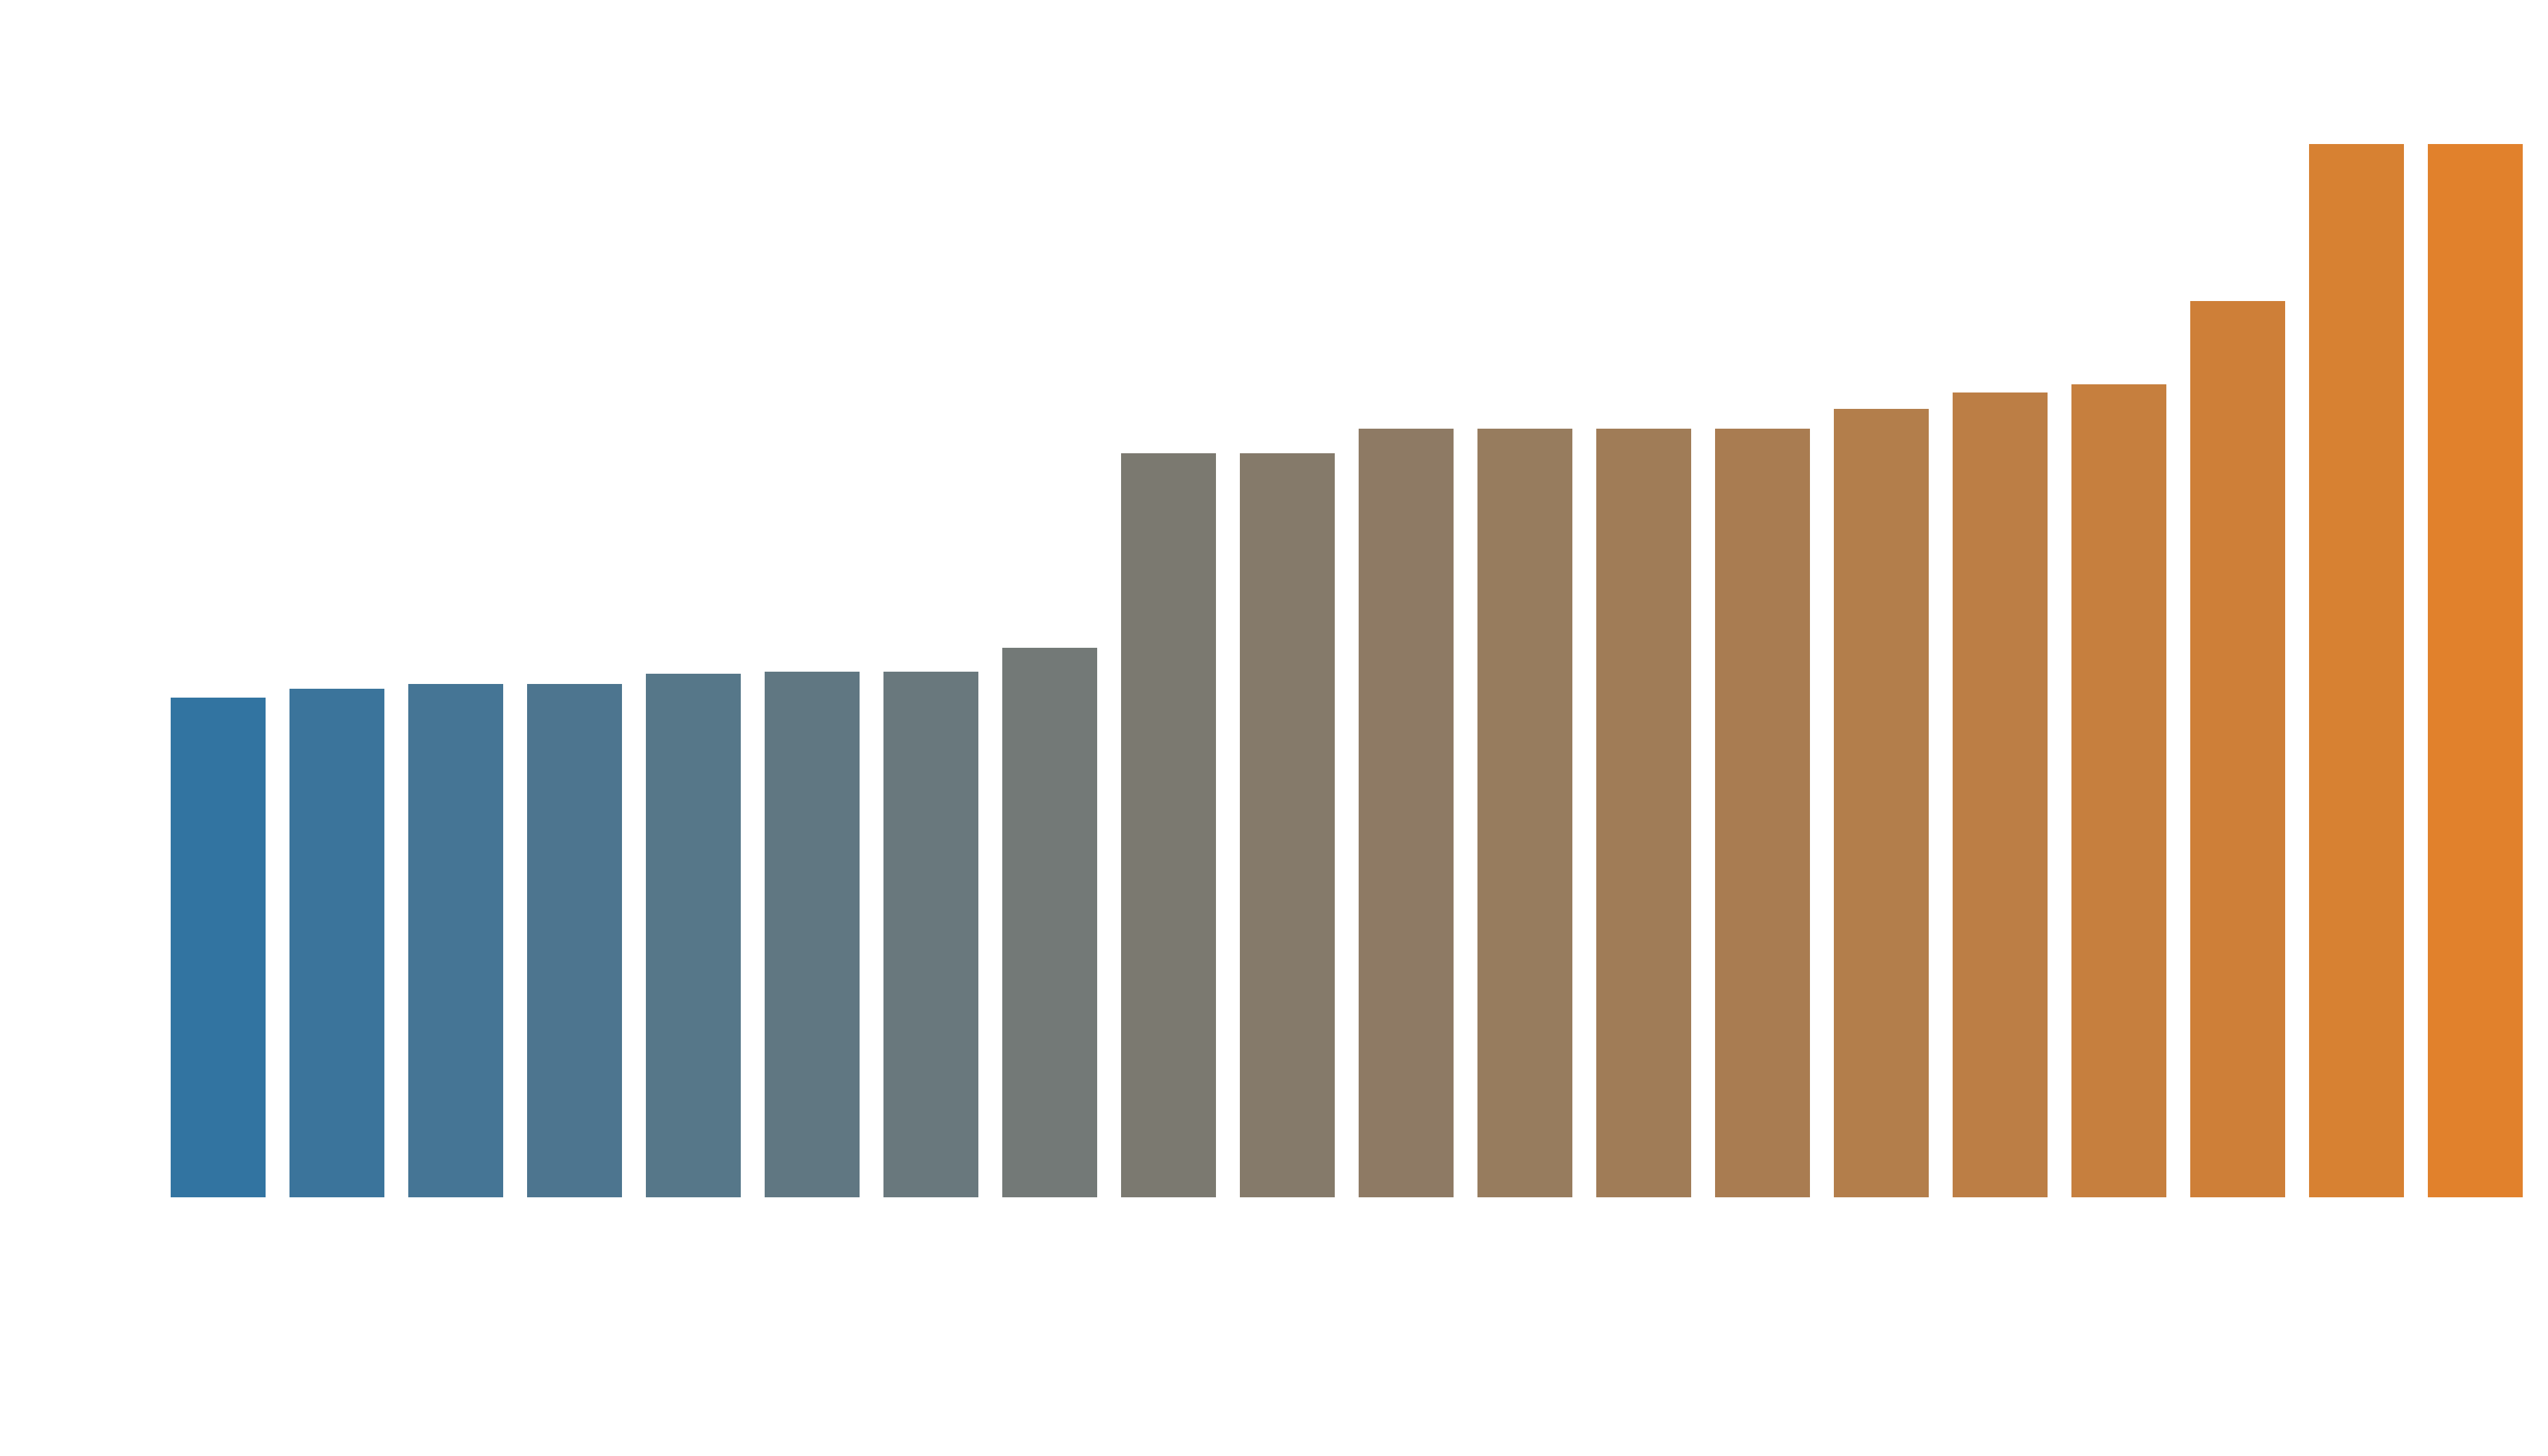

In [16]:
create_bar_plot(df=exp_df_th,
                selected_year=2021,
                file_index="16",
                ascending=True,
                threshold=20)

In [17]:
exp_df.head()

KW16_2021           KW17_2021           KW18_2021           KW19_2021  \
    Pipe TTNr   Total   Pipe TTNr   Total   Pipe TTNr   Total   Pipe TTNr   
1  8718649158  2415.0  8718658795  3022.0  8718649167  4831.0  8719905826   
2  8718649167  2415.0  8718649167  2768.0  8718649158  4831.0  8718640762   
3  8718649588  2055.0  8718649158  2768.0  8718649588  4655.0  8718643730   
4  8718649589  1863.0  8718649588  2768.0  8718649589  3197.0  8718649158   
5  8719905826  1845.0  8718686797  2715.0  8718658795  2552.0  8718649588   

            KW20_2021          ...   KW05_2023           KW06_2023          \
    Total   Pipe TTNr   Total  ...   Pipe TTNr   Total   Pipe TTNr   Total   
1  1131.0  8718649158  3593.0  ...  8718696337  3894.0  8718649167  3590.0   
2   882.0  8718649167  3593.0  ...  8750306523  3894.0  8718649158  3590.0   
3   753.0  8718649588  3593.0  ...  8705902546  3894.0  8718649588  3590.0   
4   620.0  8718640787  3009.0  ...  8718651804  3894.0  8718653366  2463.0   
5   620.0  8718640763  3009.0  ...  8718653366  3894.0  8718698387  2463.0   

    KW07_2023           KW08_2023           KW09_2023          
    Pipe TTNr   Total   Pipe TTNr   Total   Pipe TTNr   Total  
1  8719905826  2368.0  8718647378  3196.0  8718653366  2724.0  
2  8718643730  2352.0  8718654166  3196.0  8718698387  2724.0  
3  8718651804  2339.0  8718645319  3136.0  8705902546  2724.0  
4  8718696020  2339.0  8718649167  2805.0  8750306523  2724.0  
5  8718696337  2339.0  8718649158  2805.0  8718651804  2724.0  

[5 rows x 190 columns]

In [18]:
len(exp_df.iloc[:, 0])

20

In [19]:
pipe_codes = exp_df.iloc[:, ::2].values.flatten()
unique_pipes = np.array(list(set(pipe_codes)))

In [20]:
vertical_df = pd.DataFrame()

for i in range(0, len(exp_df.columns), 2):
    temp = exp_df.copy().iloc[:, i:i + 2]
    temp.columns = ['Pipe TTNr', 'Total']
    vertical_df = pd.concat([vertical_df, temp], axis=0, ignore_index=True)

In [21]:
# get the rows with unique pipes
unique_pipe_rows = vertical_df["Pipe TTNr"].unique()

In [22]:
# add the total column for the rows with same Pipe TTNr
for i in range(len(unique_pipe_rows)):
    vertical_df.loc[vertical_df["Pipe TTNr"] == unique_pipe_rows[i], "Total"] = \
        vertical_df.loc[vertical_df["Pipe TTNr"] == unique_pipe_rows[i], "Total"].sum()

In [23]:
# drop duplicate Pipe TTNrs
final_df = vertical_df.drop_duplicates(subset="Pipe TTNr",
                                       keep="first",
                                       inplace=False,
                                       ignore_index=True).sort_values(by="Total", ascending=False).copy()
final_df = final_df.reset_index(drop=True, inplace=False).copy()

In [24]:
final_df['Pipe TTNr'] = final_df['Pipe TTNr'].astype(str)

In [25]:
final_df.loc[final_df["Pipe TTNr"].apply(lambda x: x.isnumeric()), :].copy()

,Pipe TTNr,Total
0,8718649158,333052.0
1,8718649167,331384.0
2,8718649588,329355.0
3,8718654166,162240.0
4,8718647378,159287.0
...,...,...
95,8716010804,378.0
96,8716010858,139.0
97,8716011096,139.0
98,8716010856,139.0


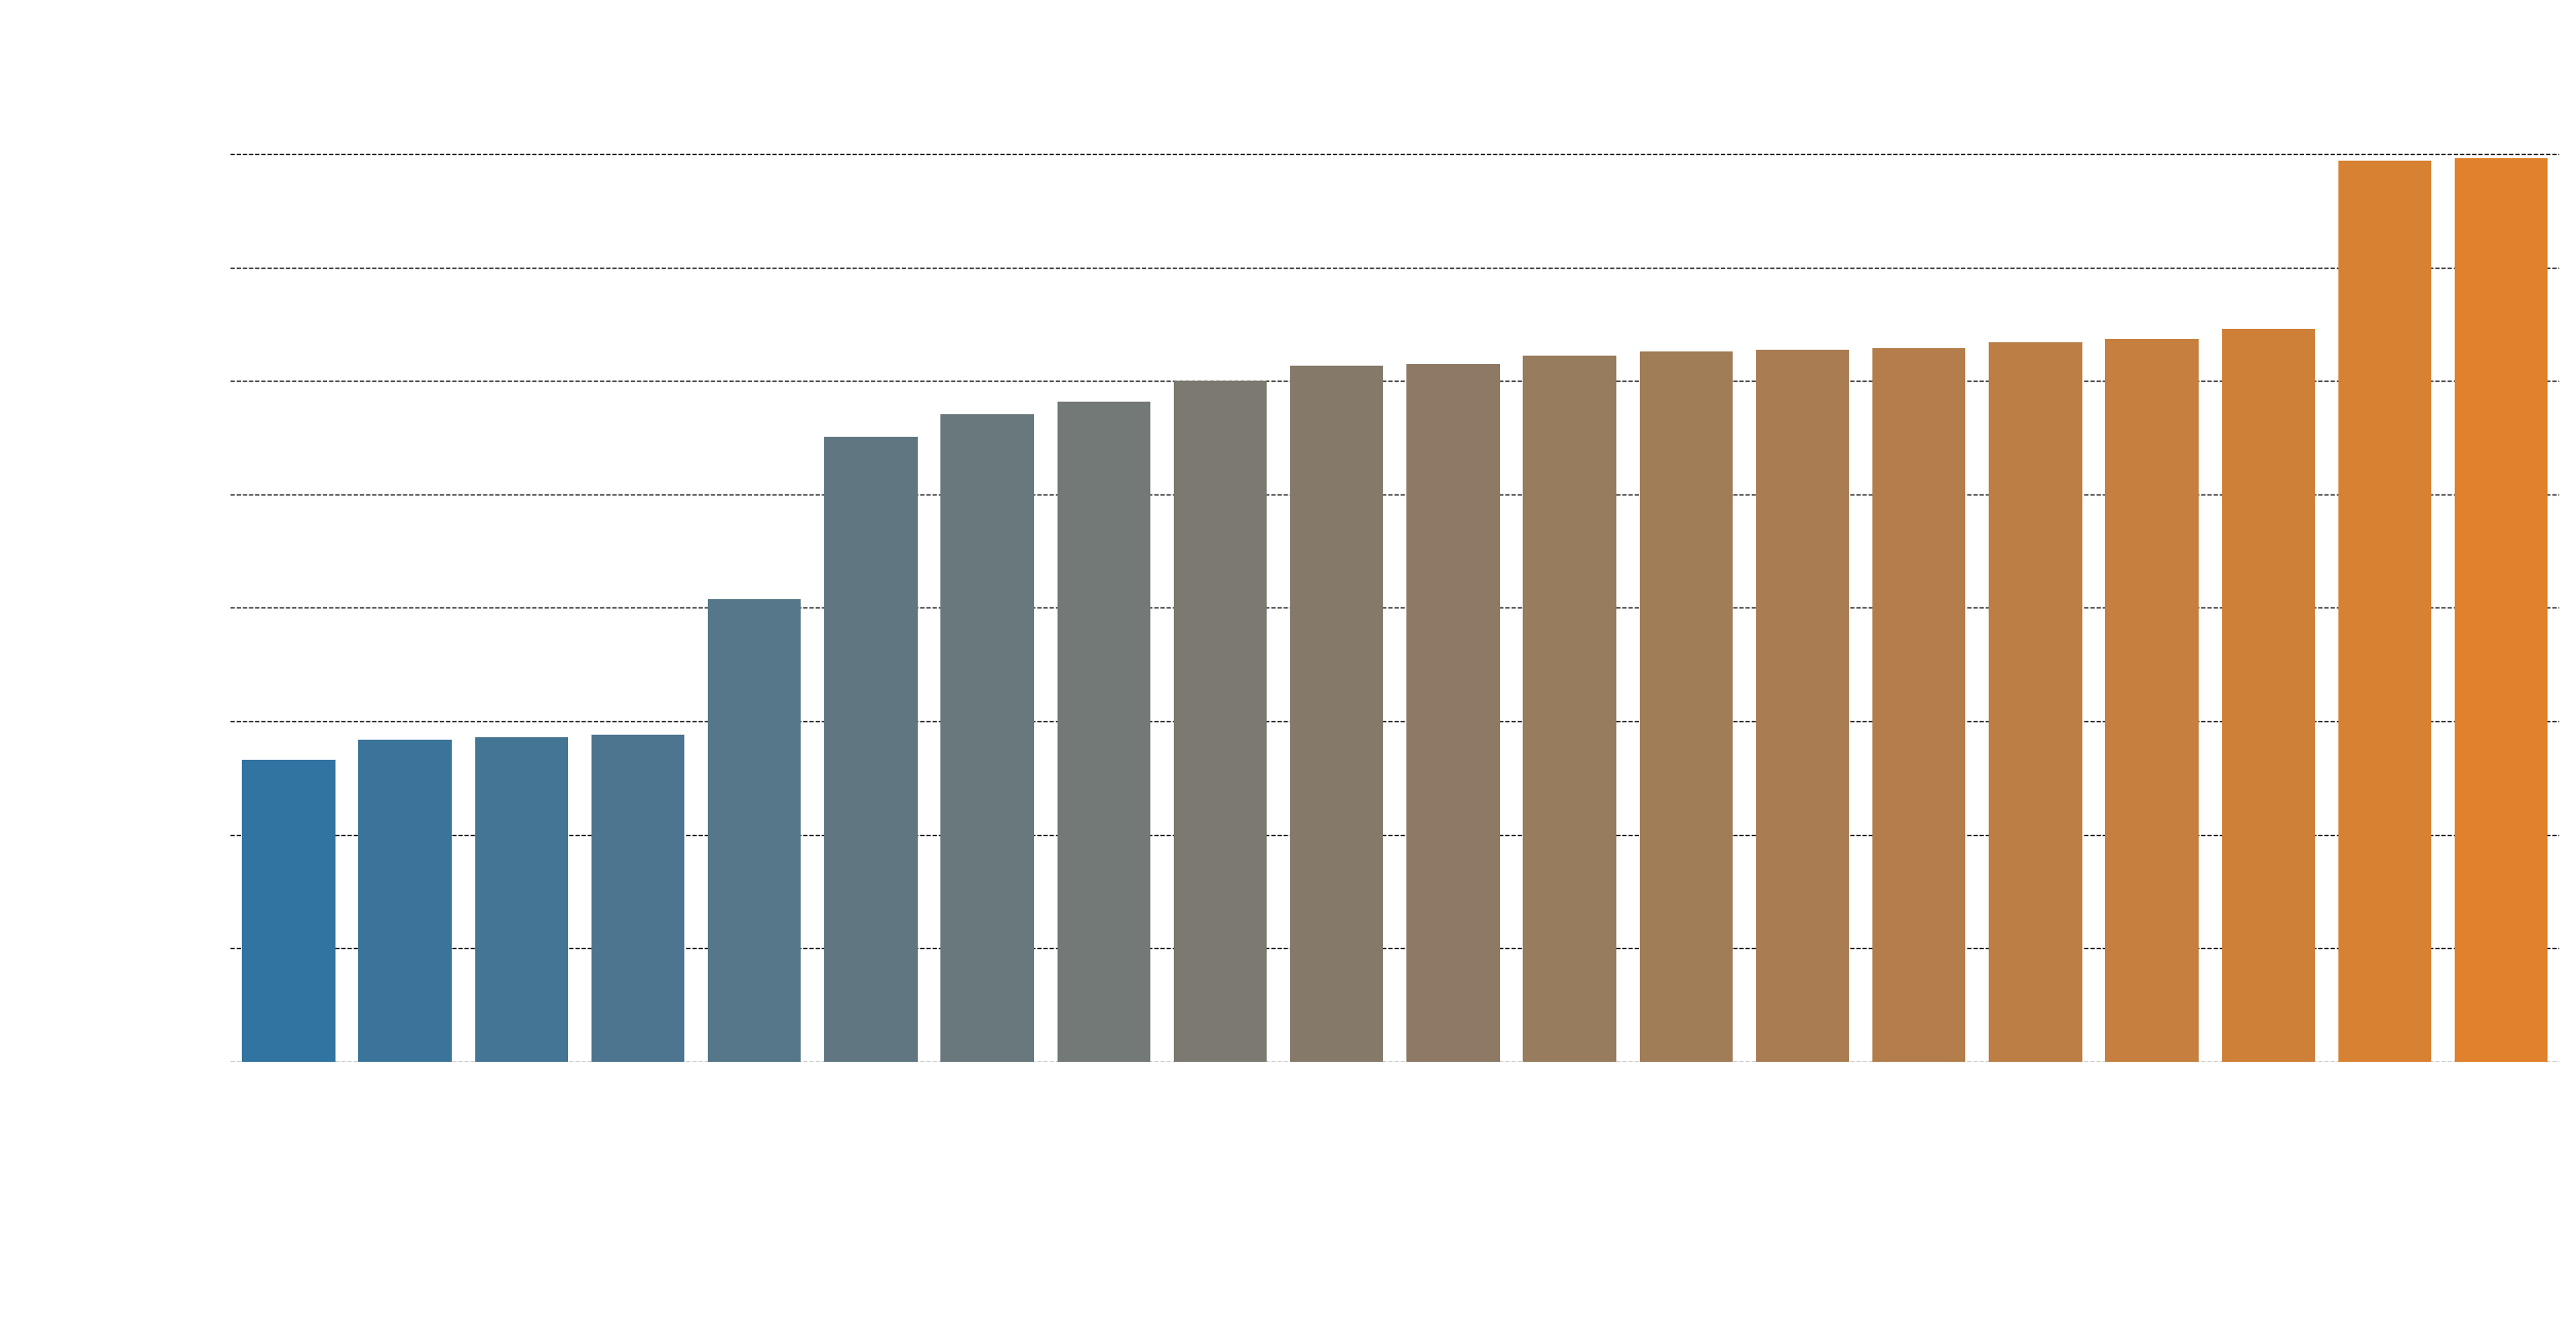

In [26]:
unique_pipe_bar_plot(pipe_df=final_df,
                     total_quantity_limit=50000,
                     fig_size=(16, 7),
                     rotation='vertical',
                     ascending=True)

In [27]:
pipes_dict = {}

for i in range(0, len(exp_df.columns), 2):
    temp = exp_df.copy().iloc[:, i:i + 2]
    pipes_dict[temp.columns[0][0]] = temp[(temp.columns[0][0], 'Pipe TTNr')].unique()

pprint(pipes_dict)

{'KW01_2022': array([8718645319, 8718654166, 8718647378, 8719905826, 8718640762,
       8718640787, 8718640763, 8718643730, 8718655925, 8718656952,
       8718649588, 8718649158, 8718649167, 8718644023, 8718644049,
       8718644024, 8718640750, 8750306523, 8718698387, 8716113919],
      dtype=object),
 'KW02_2022': array([8719905826, 8718643730, 8716113919, 8750306523, 8718699250,
       8718698387, 8718696337, 8718696020, 8718653366, 8718651804,
       8705902546, 8718655925, 8718656952, 8718640762, 8718654166,
       8718645319, 8718647378, 8718645081, 8718645112, 8718662305],
      dtype=object),
 'KW02_2023': array([8718649158, 8718649167, 8718649588, 8718658319, 8718651523,
       8705900249, 8718655112, 8718658312, 8716113919, 8750306523,
       8705902546, 8718651804, 8718653366, 8718698387, 8718699250,
       8718696337, 8718696020, 8718649589, 8718655317, 8718655316],
      dtype=object),
 'KW03_2022': array([8718640762, 8718649588, 8718649167, 8718649158, 8716013640,
       

In [28]:
# count the number of occurrences for each pipe and which weeks it occurs
pipe_occurrences, week_occurrences = {}, {}

for key, value in pipes_dict.items():
    for pipe in value:
        if pipe in pipe_occurrences.keys():
            pipe_occurrences[pipe] += 1
            week_occurrences[pipe].append(key)
        else:
            pipe_occurrences[pipe] = 1
            week_occurrences[pipe] = [key]

merged_dict = {k: [pipe_occurrences[k], week_occurrences[k]] for k in pipe_occurrences.keys()}

In [29]:
# create a dataframe from the dictionary
pipe_occurrences_df = pd.DataFrame.from_dict(merged_dict, orient='index', columns=['Occurrences', 'Weeks'])
pipe_occurrences_df.sort_values(by="Occurrences", ascending=False, inplace=False)

,Occurrences,Weeks
8718649158,92,"[KW16_2021, KW17_2021, KW18_2021, KW19_2021, K..."
8718649588,91,"[KW16_2021, KW17_2021, KW18_2021, KW19_2021, K..."
8718649167,91,"[KW16_2021, KW17_2021, KW18_2021, KW19_2021, K..."
8718640762,66,"[KW16_2021, KW17_2021, KW18_2021, KW19_2021, K..."
8716113919,66,"[KW20_2021, KW23_2021, KW25_2021, KW26_2021, K..."
...,...,...
8718642193,1,[KW35_2021]
8716011096,1,[KW43_2021]
8716010856,1,[KW43_2021]
8716010855,1,[KW43_2021]


In [30]:
pipes_in_70_df = pipe_occurrences_df.loc[pipe_occurrences_df["Occurrences"] > 70, :].sort_values(by="Occurrences",
                                                                                                 ascending=False)
pipes_in_70_df

,Occurrences,Weeks
8718649158,92,"[KW16_2021, KW17_2021, KW18_2021, KW19_2021, K..."
8718649167,91,"[KW16_2021, KW17_2021, KW18_2021, KW19_2021, K..."
8718649588,91,"[KW16_2021, KW17_2021, KW18_2021, KW19_2021, K..."


In [31]:
pipes_in_70_df = pipes_in_70_df.reset_index(inplace=False).copy()
pipes_in_70_df = pipes_in_70_df.rename(columns={"index": "Pipe TTNr"}, inplace=False).copy()

In [32]:
pipes_in_70 = pipes_in_70_df['Pipe TTNr'].values
pipes_in_70

array([8718649158, 8718649167, 8718649588])

In [33]:
all_in_one = pd.DataFrame()

In [34]:
for year, plan in file_dict.items():
    for file in plan:
        df = pd.read_excel(f'{master_dir}/{str(year)}/{file}', sheet_name='Pivot')
        df = df.fillna(0)
        df.iloc[:, 5:26] = df.iloc[:, 5:26].apply(pd.to_numeric, errors='coerce')
        df['Total'] = df.iloc[:, 5:26].sum(axis=1)
        df.loc["Hat", "Total"] = 0
        df = df.sort_values(by=['Total'], inplace=False, ascending=False, ignore_index=True).copy()

        aa = df.iloc[:, [1, -1]].copy()
        aa.index.name = aa.columns[0].split(" ")[3]
        aa.columns = ['Pipe TTNr', aa.columns[-1]]

        aa = aa.loc[aa['Pipe TTNr'].isin(pipes_in_70), :].copy()
        aa.reset_index(inplace=True)

        print(aa)
        print(f"Index: {len(aa.index)}")
        print("*" * 50)

   21.04.2021   Pipe TTNr   Total
0           0  8718649167  1731.0
1           1  8718649158  1731.0
2           2  8718649588  1371.0
3          31  8718649158   684.0
4          32  8718649588   684.0
5          33  8718649167   684.0
Index: 6
**************************************************
   29.04.2021   Pipe TTNr   Total
0           2  8718649167  1566.0
1           3  8718649158  1566.0
2           4  8718649588  1566.0
3          22  8718649167  1202.0
4          23  8718649158  1202.0
5          24  8718649588  1202.0
Index: 6
**************************************************
   07.05.2021   Pipe TTNr   Total
0          10  8718649167  1915.0
1          11  8718649158  1915.0
2          12  8718649588  1915.0
3          18  8718649167  1626.0
4          19  8718649158  1626.0
5          22  8718649588  1450.0
6          24  8718649588  1290.0
7          25  8718649167  1290.0
8          26  8718649158  1290.0
Index: 9
**************************************************
   1